# *Field line tracing example*
***

Example of tracing field lines

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sunpy
import sunpy.sun.constants

In [3]:
import pysmsh
import pysmsh.difference.staggered_curvilinear as curvilinear

In [4]:
import cider

In [5]:
RSun = sunpy.sun.constants.radius

### Load magnetogram & process

Load a HMI synoptic magnetogram

In [6]:
import cider.magnetogram.hmi

In [7]:
magnetogram_file = "../data/hmi.synoptic_mr_polfil_720s.2155.Mr_polfil.fits"

In [8]:
raw_magnetogram = cider.magnetogram.hmi.read_hmi_synoptic(magnetogram_file)

Remap to a uniform lon-lat grid which is required by the PFSS solver

In [9]:
import cider.utils.map
import cider.magnetogram

In [10]:
# Create an empty map of the requested resolution
uniform_map \
    = cider.utils.map.create_full_sun_plate_carree_map(raw_magnetogram,
                                                       deg_per_pixel=1.0,
                                                       frame=raw_magnetogram.coordinate_frame.name)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [11]:
remapped_magnetogram = cider.magnetogram.regrid_to_grid_of_map(raw_magnetogram, uniform_map)

Balance the signed flux of the magnetogram

In [12]:
balanced_magnetogram = cider.magnetogram.Balance.multiplicative(remapped_magnetogram)

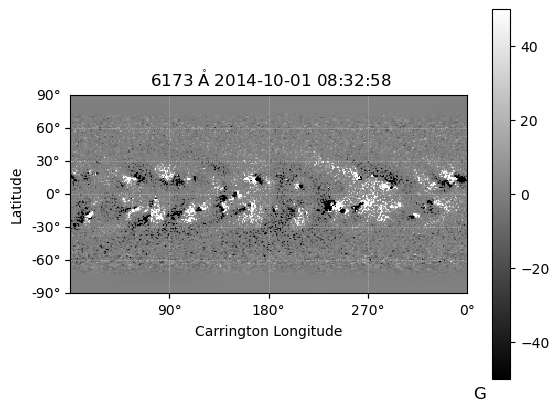

In [13]:
balanced_magnetogram.peek(vmin=-50, vmax=50, norm=None)

### Compute the PFSS model

In [14]:
import cider.models.pfss

Specify the radial grid edge coordinates. For the PFSS model, the outer radius defines the source surface

In [15]:
r = np.linspace(1.0, 2.5, 128+1)*RSun

In [16]:
# Instantiate the model
pfss = cider.models.pfss.PotentialFieldSourceSurfaceModel(balanced_magnetogram, r)

In [17]:
# Compute the solution
pfss.compute()

In [18]:
# Compute the magnetic field
magnetic_field = pfss.magnetic_field()

### Tracing field lines

Tracing field lines requires 
 1. A method to compute (interpolate) the vector field at any arbitrary point from the grid values
 2. Integrating the ODE defining a streamline, $\frac{d \mathbf{x}(s)}{ds} \times \mathbf{b}(\mathbf{x}(s)) = 0$

Many different methodologies could be employed for both tasks, with varying effects on the accuracy of the computed stream line. For applications requiring a high level of accuracy, care should be taken in choosing these.

As a simple approach, we here use trilinear interpolation of the magnetic field components that have been averaged to the nodes (corners) of the mesh.

In [19]:
import cider.utils.interpolation
import cider.utils.tracer

Average data to nodes

In [20]:
nodal_magnetic_field = cider.utils.interpolation.average_face_staggered_to_nodal(magnetic_field)

Create the interpolator

In [21]:
interpolator = cider.utils.interpolation.NodalSphericalShellVectorFieldInterpolator(nodal_magnetic_field)

Initialize the streamline tracer. Default parameters, which may or may not be suitable for your particular case, are set by the constructor.

In [22]:
tracer = cider.utils.tracer.SphericalShellMidPointStreamLineTracer(interpolator)

In [23]:
# As an example, modify the maximum length of a stream line
tracer.max_path_length = 3.0*RSun.si.value

Trace the streamline starting from a given point (given in spherical $(r, \theta, \phi$) coordinates), either in the direction of the field (reverse=False) or opposite to the direction of the field (reverse=True). The tracing is performed until it is terminated, and the end point of the streamline is returned.

In [24]:
beg_pt = (2.0*RSun.si.value, 0.5*np.pi, 0.5*np.pi)
reverse = False

In [25]:
end_pt = tracer.compute(beg_pt, reverse)

In [26]:
end_pt

array([6.95700000e+08, 1.42482276e+00, 1.70325891e+00])

By default, the coordinates of the streamline are not recorded due to performance degredation when doing so. Recording of points can be switched on:

In [27]:
tracer.record_points = True

In [28]:
# Retrace
end_pt = tracer.compute(beg_pt, reverse)

In [29]:
# Each coordinate is now stored in tracer.points
list(tracer.points[0:5])

[array([1.39140000e+09, 1.57079633e+00, 1.57079633e+00]),
 array([1.39140000e+09, 1.57079633e+00, 1.57079633e+00]),
 array([1.38940518e+09, 1.57109681e+00, 1.57078322e+00]),
 array([1.38741060e+09, 1.57139861e+00, 1.57077151e+00]),
 array([1.38541624e+09, 1.57170166e+00, 1.57076131e+00])]

Using the tracer, for example the open and closed regions can be computed.

In [30]:
import cider.analysis.open_closed

In [31]:
# Switch off recording of points
tracer.record_points = False

In [32]:
%%time
open_closed_map \
    = cider.analysis.open_closed.compute_open_closed_map(pfss.magnetogram,
                                                         deg_per_pixel=2.0,
                                                         start_radius=1.01*RSun,
                                                         open_radius=2.45*RSun,
                                                         tracer=tracer)

CPU times: user 9.34 s, sys: 26 ms, total: 9.36 s
Wall time: 9.39 s


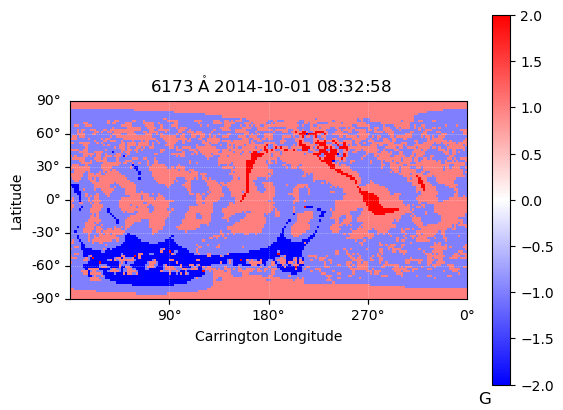

In [33]:
open_closed_map.peek(cmap='bwr')

The open field can be plotted together with the magnetogram by applying a mask:

In [34]:
masked_data = np.copy(open_closed_map.data)
masked_data[np.where(np.abs(open_closed_map.data) < 1.5)] = np.NaN

In [35]:
masked_open_closed_map = sunpy.map.Map(masked_data, open_closed_map.meta)

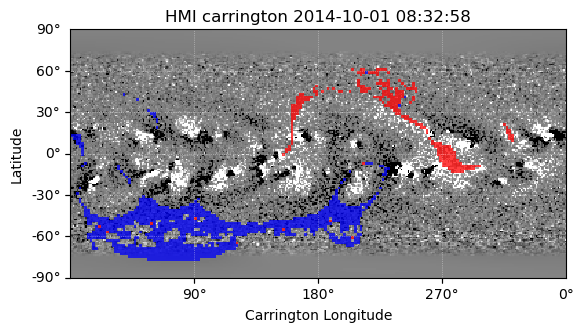

In [36]:
fig = plt.figure()

ax = fig.add_subplot(projection=pfss.magnetogram)

pfss.magnetogram.plot(axes=ax, vmin=-20, vmax=20)

# Note: this uses autoalign to align the two maps of different resolution..
masked_open_closed_map.plot(axes=ax, autoalign=True, alpha=0.75, cmap="bwr", norm=None)

The PFSS result can be output to VTK for external visualization

In [37]:
import os
import pyevtk.hl as evtk

In [38]:
B = nodal_magnetic_field

evtk.gridToVTK("../data/" + os.path.basename(magnetogram_file).replace('.fits', '.pfss'),
               B.mesh.edges.r/RSun.si.value,
               B.mesh.edges.clt,
               B.mesh.edges.lon,
               pointData={"Br" : B.data[0], "Bt" : B.data[1], "Bp" : B.data[2]})

'/Users/jpomoell/cider/data/hmi.synoptic_mr_polfil_720s.2155.Mr_polfil.pfss.vtr'

***